In [1]:
# First some imports that we'll use below
from __future__ import print_function
import treecorr
#import fitsio
import numpy
import math
import time
import pprint
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.ticker import StrMethodFormatter, NullFormatter 
from scipy import signal
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import Distance
from astropy.cosmology import WMAP5 as cosmo5
from astropy.cosmology import WMAP9 as cosmo9
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import Planck13, z_at_value
from astropy import cosmology
import healpy as hp
import random
from collections import Counter
from astropy.io import ascii 
import os
import mockmaps
from scipy import stats
from scipy import integrate
from scipy import signal
from scipy.signal import find_peaks
from scipy.stats import norm
import matplotlib.mlab as mlab
import multiprocessing as mp
from joblib import Parallel, delayed, parallel_backend
import NK_Correlation_GW_multEvents_Final as NK_GW
import pickle
from astropy import modeling

In [2]:
def combineH0plotNKFinalized (directory1, directory2, outdir):
    for r,di, f in os.walk(directory1):
        for file in f:
            if 'log' not in file:
                print(file)
                pickle_in = open(os.path.join(r, file) ,'rb')
                nk_list1 = (pickle.load(pickle_in))
                file_name = file
    for r,di, f in os.walk(directory2):
        for file in f:
            if 'log' not in file:
                pickle_in = open(os.path.join(r, file) ,'rb')
                nk_list2 = (pickle.load(pickle_in))
    nk_combine = numpy.concatenate([nk_list1, nk_list2])
    pickle_out = open((outdir + file_name + '_combine' ) ,"wb")
    pickle.dump(nk_combine, pickle_out)
    pickle_out.close()

In [3]:
def plotNKFinalized(directory, h0_values, rk_dir = None):
    #nk_list = [treecorr.NKCorrelation(min_sep= 10, max_sep=1000 , nbins=100) for i in range (len(h0_values))]
    nk_list = []
    for r, di, f in os.walk(directory):
        for file in f:
            if '_NKObject' in file:
                pickle_in = open(os.path.join(r, file) ,'rb')
                nk_list.append(pickle.load(pickle_in))
            #nk_combine.__iadd__(nk_corr.copy())
    if (rk_dir is not None):
        rk_list = []
        for r, di, f in os.walk(rk_dir):
            for file in f:
                if '_NKObject_Randoms' in file:
                    pickle_in = open(os.path.join(r, file) ,'rb')
                    rk_list.append(pickle.load(pickle_in))
    r_nk_tot = []
    xi_nk_tot = []
    max_r_tot = []
    max_xi_tot = []
    for i in range(len(h0_values)):
        nk_combine = treecorr.NKCorrelation(min_sep= 3, max_sep=500 , nbins=50)
        rk_combine = treecorr.NKCorrelation(min_sep= 3, max_sep=500 , nbins=50)
        for j in range(len(nk_list)):
            nk_combine.__iadd__(nk_list[j][i])
            if(rk_dir is not None):
                rk_combine.__iadd__(rk_list[j][i])
        rand_nk, xirand_nk, rk_combine, varrand_xi= NK_GW.nk_finalize(rk_combine, 1)
        r_nk, xi_nk, nk_one, var_xi= NK_GW.nk_finalize(nk_combine, 1, rk_combine)
        max_xi = numpy.max(xi_nk)
        max_r = r_nk[numpy.argmax(xi_nk)]
        r_nk_tot.append(r_nk)
        xi_nk_tot.append(xi_nk)
        max_r_tot.append(max_r)
        max_xi_tot.append(max_xi)
    return r_nk_tot, xi_nk_tot

In [4]:
def plotCombineAverage(h0_values, directory, rk_dir = None):
    #nk_list = [treecorr.NKCorrelation(min_sep= 10, max_sep=1000 , nbins=100) for i in range (len(h0_values))]
    nk_list = []
    for r, di, f in os.walk(directory):
        for file in f:
            if '_NKObject' in file:
                pickle_in = open(os.path.join(r, file) ,'rb')
                nk_list.append(pickle.load(pickle_in))
                #nk_combine.__iadd__(nk_corr.copy())
    if (rk_dir is not None):
        rk_list = []
        for r, di, f in os.walk(rk_dir):
            for file in f:
                if '_NKObject_Randoms' in file:
                    pickle_in = open(os.path.join(r, file) ,'rb')
                    rk_list.append(pickle.load(pickle_in))
    r_nk_tot = []
    xi_nk_tot = []
    max_r_tot = []
    max_xi_tot = []
    for i in range(len(h0_values)):
        nk_combine = treecorr.NKCorrelation(min_sep= 3, max_sep=500 , nbins=50)
        #rk_combine = treecorr.NKCorrelation(min_sep= 10, max_sep=1000 , nbins=100)
        xi_combine = numpy.full(50, 0.0)
        for j in range(len(nk_list)):
            rk_corr = None
            if(rk_dir is not None):
                r_nk, xi_nk, rk_corr, var_xi= NK_GW.nk_finalize(rk_list[j][i], 1)
            r_nk, xi_nk, nk_one, var_xi= NK_GW.nk_finalize(nk_list[j][i], 1, rk_corr)
            xi_combine += (xi_nk)
        xi_combine = xi_combine/len(nk_list)
        #print(nk_combine.raw_xi)
        #print(nk_combine.weight)
        #print(nk_combine.raw_xi/nk_combine.weight )
        #r_nk, xi_nk, nk_one, var_xi= NK_GW.nk_finalize(nk_combine, 1)
        max_xi = numpy.max(xi_combine)
        max_r = r_nk[numpy.argmax(xi_combine)]
        r_nk_tot.append(r_nk)
        xi_nk_tot.append(xi_combine)
        max_r_tot.append(max_r)
        max_xi_tot.append(max_xi)
    return max_xi_tot

In [5]:
def plotCombineMultiply(h0_values, directory, rk_dir = None):
    #nk_list = [treecorr.NKCorrelation(min_sep= 10, max_sep=1000 , nbins=100) for i in range (len(h0_values))]
    nk_list = []
    for r, di, f in os.walk(directory):
        for file in f:
            if '_NKObject' in file:
                pickle_in = open(os.path.join(r, file) ,'rb')
                nk_list.append(pickle.load(pickle_in))
                #nk_combine.__iadd__(nk_corr.copy())
    if (rk_dir is not None):
        rk_list = []
        for r, di, f in os.walk(rk_dir):
            for file in f:
                if '_NKObject_Randoms' in file:
                    pickle_in = open(os.path.join(r, file) ,'rb')
                    rk_list.append(pickle.load(pickle_in))
    r_nk_tot = []
    xi_nk_tot = []
    max_r_tot = []
    max_xi_tot = []
    for i in range(len(h0_values)):
        nk_combine = treecorr.NKCorrelation(min_sep= 3, max_sep=500 , nbins=50)
        #rk_combine = treecorr.NKCorrelation(min_sep= 10, max_sep=1000 , nbins=100)
        xi_combine = numpy.full(50, 1.0)
        for j in range(len(nk_list)):
            rk_corr = None
            if(rk_dir is not None):
                r_nk, xi_nk, rk_corr, var_xi= NK_GW.nk_finalize(rk_list[j][i], 1)
            r_nk, xi_nk, nk_one, var_xi= NK_GW.nk_finalize(nk_list[j][i], 1, rk_corr)
            xi_combine *= (xi_nk)
        #xi_combine = xi_combine/len(nk_list)
        #print(nk_combine.raw_xi)
        #print(nk_combine.weight)
        #print(nk_combine.raw_xi/nk_combine.weight )
        #r_nk, xi_nk, nk_one, var_xi= NK_GW.nk_finalize(nk_combine, 1)
        max_xi = numpy.max(xi_combine)
        max_r = r_nk[numpy.argmax(xi_combine)]
        r_nk_tot.append(r_nk)
        xi_nk_tot.append(xi_combine)
        max_r_tot.append(max_r)
        max_xi_tot.append(max_xi)
    return max_xi_tot

In [6]:
def plotCombineTreeCorr(h0_values, directory, rand_directory = None):
    r, xi = plotNKFinalized(directory, h0_values, rand_directory)
    max_xi_tot = []
    for i in range(0, len(h0_values)):
        max_xi_tot.append(numpy.max(xi[i]))
    return max_xi_tot

In [7]:
from scipy.optimize import curve_fit
def gaussian(x, amplitude, mean, stddev):
    return amplitude *numpy.exp(-((x - mean) / 2 / stddev)**2)

# BCC weights^2

In [18]:
outdir = 'des40a/Final_BCC_NKObjects/all_events/NKObjects'
outdir_rand = 'des40a/Final_BCC_NKObjects/all_events/NKObjects_Randoms'
h0_values =numpy.arange(40,102,2)
max_xi = plotCombineTreeCorr(h0_values, outdir, outdir_rand)

In [19]:
popt, pcov = curve_fit(gaussian, h0_values,  max_xi,  p0 = [1, 70, 5] )

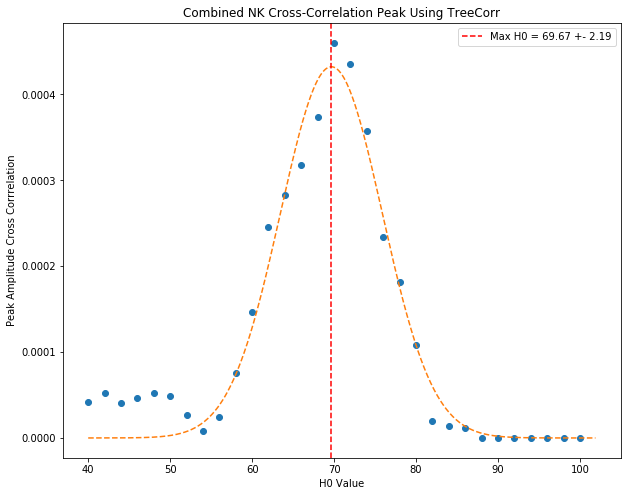

In [41]:
# 40 events
x = numpy.arange(40,102,0.1)
y = gaussian(x,*popt)
plt.figure(figsize=(10, 8))
plt.plot(h0_values, max_xi, 'o', x, y, '--')
plt.axvline( popt[1],color = 'r', linestyle = '--', label = 'Max H0 = %.2f +- %.2f' % (popt[1], popt[2]) )
plt.title('Combined NK Cross-Correlation Peak Using TreeCorr')
plt.xlabel('H0 Value')
plt.ylabel('Peak Amplitude Cross Corrrelation')
plt.legend(loc = 'upper right')
plt.show()

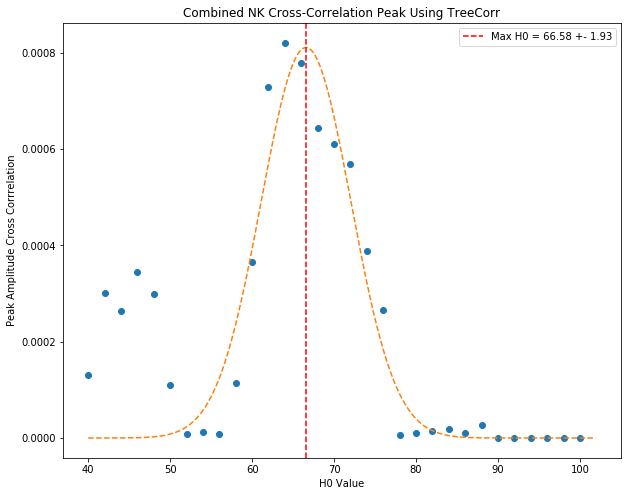

In [20]:
# 39 events without 480
x = numpy.arange(40,102,0.1)
y = gaussian(x,*popt)
plt.figure(figsize=(10, 8))
plt.plot(h0_values, max_xi, 'o', x, y, '--')
plt.axvline( popt[1],color = 'r', linestyle = '--', label = 'Max H0 = %.2f +- %.2f' % (popt[1], popt[2]) )
plt.title('Combined NK Cross-Correlation Peak Using TreeCorr')
plt.xlabel('H0 Value')
plt.ylabel('Peak Amplitude Cross Corrrelation')
plt.legend(loc = 'upper right')
plt.show()

# BCC weights^1

In [32]:
outdir = 'des40a/Final_BCC1Weight_NKObjects/all_events/NKObjects'
outdir_rand = 'des40a/Final_BCC1Weight_NKObjects/all_events/NKObjects_Randoms'
h0_values =numpy.arange(40,102,2)
max_xi = plotCombineTreeCorr(h0_values, outdir, outdir_rand)

In [33]:
popt, pcov = curve_fit(gaussian, h0_values,  max_xi,  p0 = [1, 70, 5] )

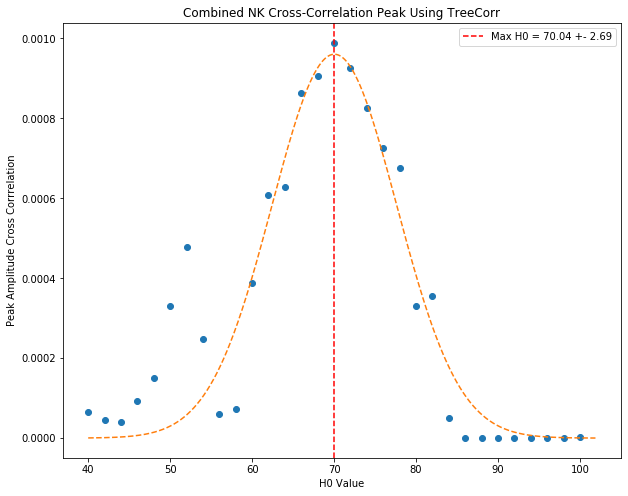

In [17]:
# 40 events
x = numpy.arange(40,102,0.1)
y = gaussian(x,*popt)
plt.figure(figsize=(10, 8))
plt.plot(h0_values, max_xi, 'o', x, y, '--')
plt.axvline( popt[1],color = 'r', linestyle = '--', label = 'Max H0 = %.2f +- %.2f' % (popt[1], popt[2]) )
plt.title('Combined NK Cross-Correlation Peak Using TreeCorr')
plt.xlabel('H0 Value')
plt.ylabel('Peak Amplitude Cross Corrrelation')
plt.legend(loc = 'upper right')
plt.show()

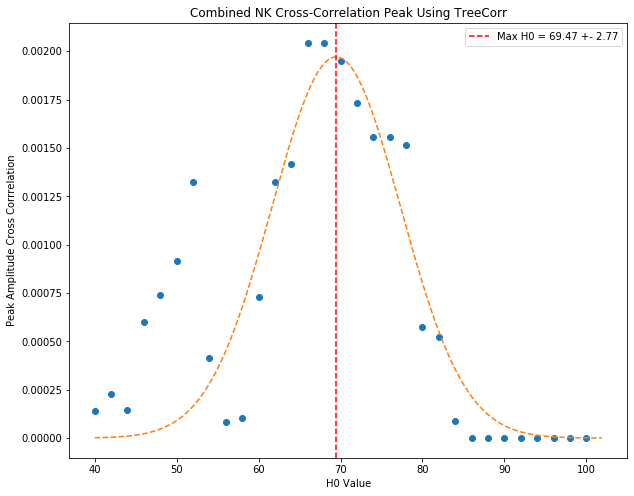

In [14]:
# 39 events without 480
x = numpy.arange(40,102,0.1)
y = gaussian(x,*popt)
plt.figure(figsize=(10, 8))
plt.plot(h0_values, max_xi, 'o', x, y, '--')
plt.axvline( popt[1],color = 'r', linestyle = '--', label = 'Max H0 = %.2f +- %.2f' % (popt[1], popt[2]) )
plt.title('Combined NK Cross-Correlation Peak Using TreeCorr')
plt.xlabel('H0 Value')
plt.ylabel('Peak Amplitude Cross Corrrelation')
plt.legend(loc = 'upper right')
plt.show()

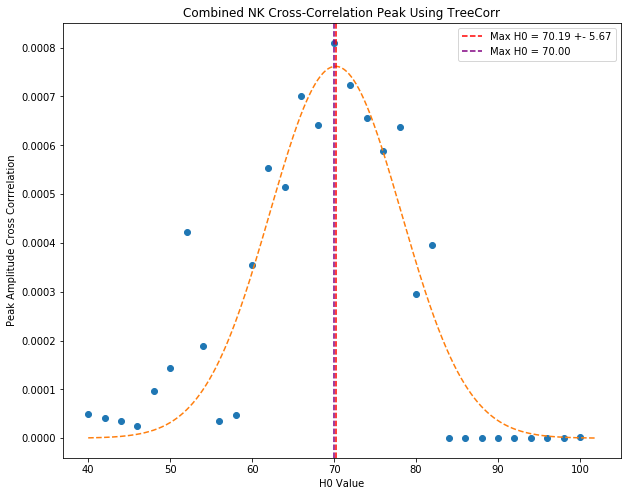

In [34]:
# 38 events without 1987 and 36
x = numpy.arange(40,102,0.1)
y = gaussian(x,*popt)
plt.figure(figsize=(10, 8))
plt.plot(h0_values, max_xi, 'o', x, y, '--')
plt.axvline( popt[1],color = 'r', linestyle = '--', label = 'Max H0 = %.2f +- %.2f' % (popt[1], popt[2]) )
plt.axvline(h0_max ,color = 'purple', linestyle = '--', label = 'Max H0 = %.2f' % (h0_max) )
plt.title('Combined NK Cross-Correlation Peak Using TreeCorr')
plt.xlabel('H0 Value')
plt.ylabel('Peak Amplitude Cross Corrrelation')
plt.legend(loc = 'upper right')
plt.show()

# BCC No weights

In [24]:
outdir = 'des40a/Final_BBCNoWeights_NKObjects/all_events/NKObjects'
outdir_rand = 'des40a/Final_BBCNoWeights_NKObjects/all_events/NKObjects_Randoms'
h0_values =numpy.arange(40,102,2)
max_xi = plotCombineTreeCorr(h0_values, outdir, outdir_rand)

In [25]:
from scipy.optimize import curve_fit
def gaussian(x, amplitude, mean, stddev):
    return amplitude * numpy.exp(-((x - mean) / 4 / stddev)**2)

popt, pcov = curve_fit(gaussian, h0_values,  max_xi,  p0 = [1, 70, 5] )

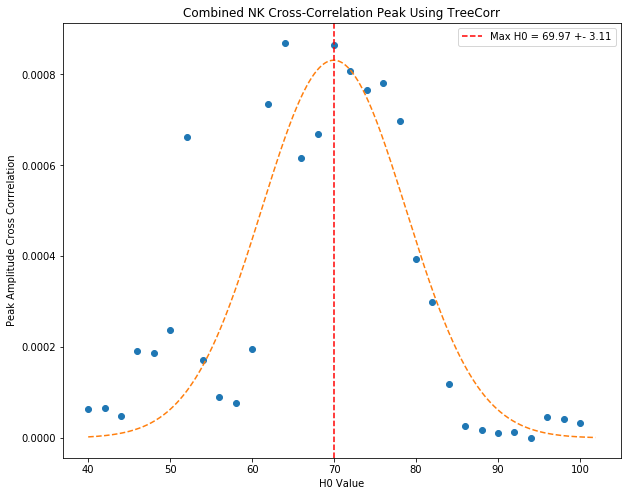

In [26]:
x = numpy.arange(40,102,0.1)
y = gaussian(x,*popt)
plt.figure(figsize=(10, 8))
plt.plot(h0_values, max_xi, 'o', x, y, '--')
plt.axvline( popt[1],color = 'r', linestyle = '--', label = 'Max H0 = %.2f +- %.2f' % (popt[1], popt[2]) )
plt.title('Combined NK Cross-Correlation Peak Using TreeCorr')
plt.xlabel('H0 Value')
plt.ylabel('Peak Amplitude Cross Corrrelation')
plt.legend(loc = 'upper right')
plt.show()

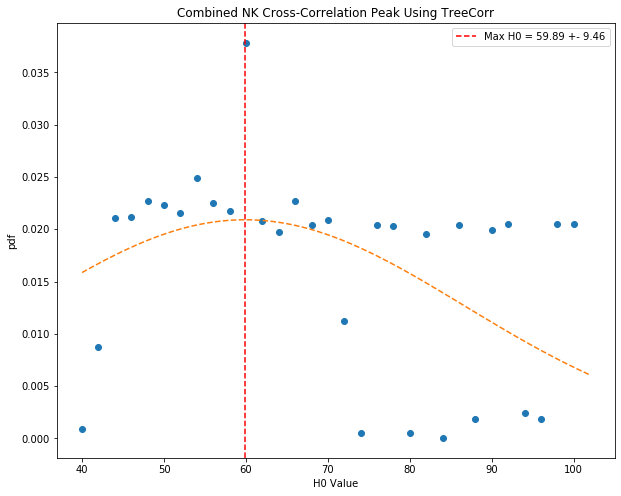

In [17]:
integral = integrate.simps(y,x)
x = numpy.arange(40,102,0.1)
y = gaussian(x,*popt)
plt.figure(figsize=(10, 8))
plt.plot(h0_values, max_xi/integral, 'o', x, y/integral, '--')
plt.axvline( popt[1],color = 'r', linestyle = '--', label = 'Max H0 = %.2f +- %.2f' % (popt[1], popt[2]) )
plt.title('Combined NK Cross-Correlation Peak Using TreeCorr')
plt.xlabel('H0 Value')
plt.ylabel('pdf')
plt.legend(loc = 'upper right')
plt.show()

# Mock Gaussian Using multiplication

In [14]:
max_xi

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [19]:
outdir = 'des40a/mockTest/Final_Mock_NKObjects/all_events/NKObjects'
outdir_rand = 'des40a/mockTest//Final_Mock_NKObjects/all_events/NKObjects_Randoms'
h0_values =numpy.arange(40,102,2)
max_xi = plotCombineTreeCorr(h0_values, outdir, outdir_rand)

In [20]:
popt, pcov = curve_fit(gaussian, h0_values,  max_xi,  p0 = [1, 70, 5] )

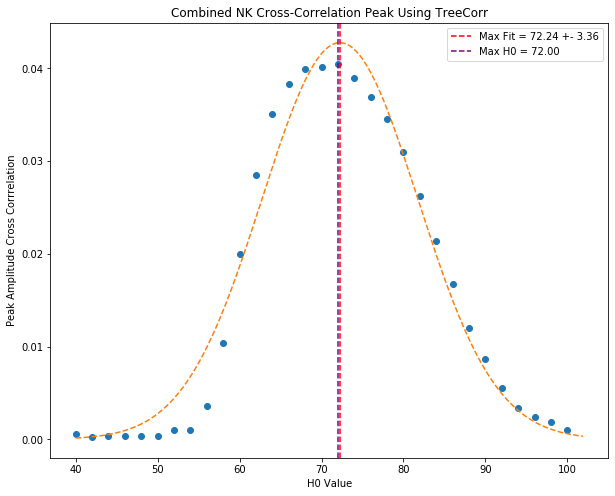

In [21]:
# 1 events
integral = integrate.simps(max_xi,h0_values)
popt, pcov = curve_fit(gaussian, h0_values,  max_xi/integral,  p0 = [1, 70, 5] )
x = numpy.arange(40,102,0.1)
y = gaussian(x,*popt)
h0_max = h0_values[numpy.argmax(max_xi)]
plt.figure(figsize=(10, 8))
plt.plot(h0_values, max_xi/integral, 'o', x, y, '--')
plt.axvline( popt[1],color = 'r', linestyle = '--', label = 'Max Fit = %.2f +- %.2f' % (popt[1], popt[2]) )
plt.axvline(h0_max ,color = 'purple', linestyle = '--', label = 'Max H0 = %.2f' % (h0_max) )
plt.title('Combined NK Cross-Correlation Peak Using TreeCorr')
plt.xlabel('H0 Value')
plt.ylabel('Peak Amplitude Cross Corrrelation')
plt.legend(loc = 'upper right')
#plt.ylim(0, numpy.max(max_xi))
plt.show()

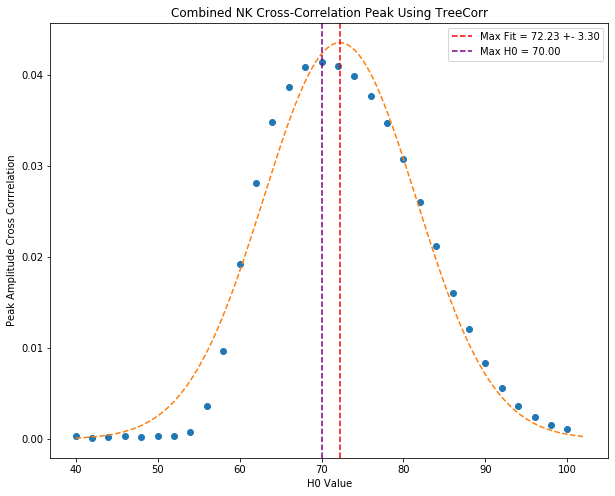

In [18]:
# 25 events
integral = integrate.simps(max_xi,h0_values)
popt, pcov = curve_fit(gaussian, h0_values,  max_xi/integral,  p0 = [1, 70, 5] )
x = numpy.arange(40,102,0.1)
y = gaussian(x,*popt)
h0_max = h0_values[numpy.argmax(max_xi)]
plt.figure(figsize=(10, 8))
plt.plot(h0_values, max_xi/integral, 'o', x, y, '--')
plt.axvline( popt[1],color = 'r', linestyle = '--', label = 'Max Fit = %.2f +- %.2f' % (popt[1], popt[2]) )
plt.axvline(h0_max ,color = 'purple', linestyle = '--', label = 'Max H0 = %.2f' % (h0_max) )
plt.title('Combined NK Cross-Correlation Peak Using TreeCorr')
plt.xlabel('H0 Value')
plt.ylabel('Peak Amplitude Cross Corrrelation')
plt.legend(loc = 'upper right')
#plt.ylim(0, numpy.max(max_xi))
plt.show()

In [29]:
outdir = 'des40a/mockTest/Final_Mock_NKObjects/all_events/NKObjects'
outdir_rand = 'des40a/mockTest/Final_Mock_NKObjects/all_events/NKObjects_Randoms'
h0_values =numpy.arange(40,102,2)
max_xi = plotCombineMultiply(h0_values, outdir)#, outdir_rand)

In [30]:
popt, pcov = curve_fit(gaussian, h0_values,  max_xi,  p0 = [1, 70, 5] )

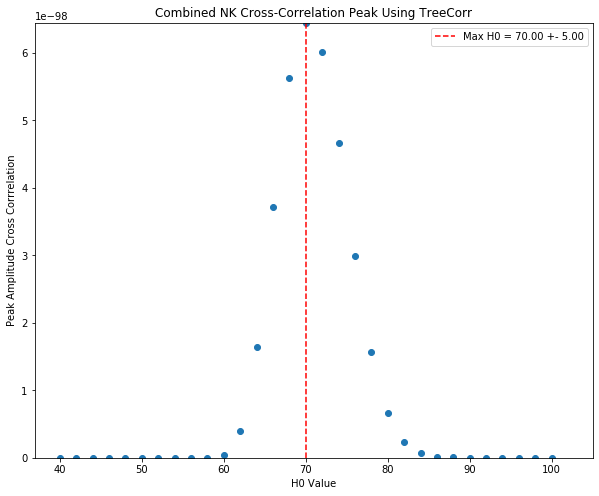

In [31]:
x = numpy.arange(40,102,0.1)
y = gaussian(x,*popt)
plt.figure(figsize=(10, 8))
plt.plot(h0_values, max_xi, 'o', x, y, '--')
plt.axvline( popt[1],color = 'r', linestyle = '--', label = 'Max H0 = %.2f +- %.2f' % (popt[1], popt[2]) )
plt.title('Combined NK Cross-Correlation Peak Using TreeCorr')
plt.xlabel('H0 Value')
plt.ylabel('Peak Amplitude Cross Corrrelation')
plt.legend(loc = 'upper right')
plt.ylim(0, numpy.max(max_xi))
plt.show()

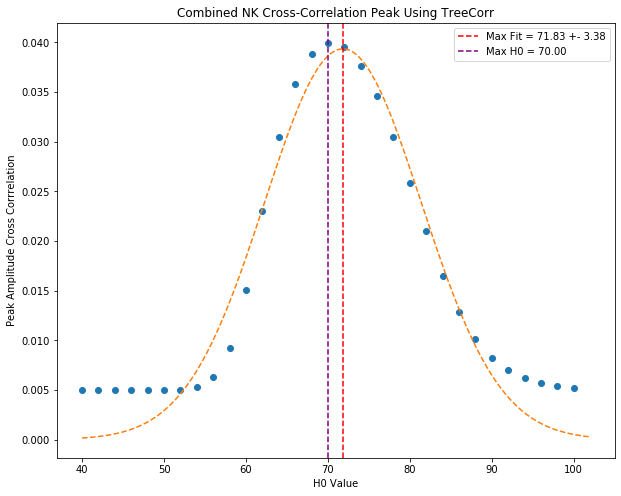

In [20]:
# 5 events
integral = integrate.simps(max_xi,h0_values)
popt, pcov = curve_fit(gaussian, h0_values,  max_xi/integral,  p0 = [1, 70, 5] )
x = numpy.arange(40,102,0.1)
y = gaussian(x,*popt)
h0_max = h0_values[numpy.argmax(max_xi)]
plt.figure(figsize=(10, 8))
plt.plot(h0_values, max_xi/integral, 'o', x, y, '--')
plt.axvline( popt[1],color = 'r', linestyle = '--', label = 'Max Fit = %.2f +- %.2f' % (popt[1], popt[2]) )
plt.axvline(h0_max ,color = 'purple', linestyle = '--', label = 'Max H0 = %.2f' % (h0_max) )
plt.title('Combined NK Cross-Correlation Peak Using TreeCorr')
plt.xlabel('H0 Value')
plt.ylabel('Peak Amplitude Cross Corrrelation')
plt.legend(loc = 'upper right')
#plt.ylim(0, numpy.max(max_xi))
plt.show()

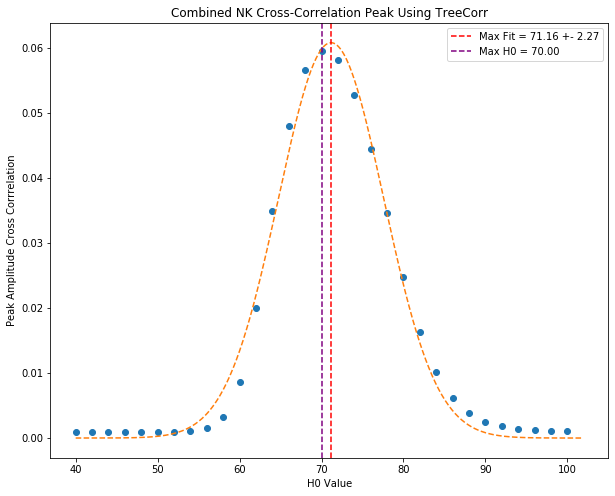

In [24]:
# 10 events
integral = integrate.simps(max_xi,h0_values)
popt, pcov = curve_fit(gaussian, h0_values,  max_xi/integral,  p0 = [1, 70, 5] )
x = numpy.arange(40,102,0.1)
y = gaussian(x,*popt)
h0_max = h0_values[numpy.argmax(max_xi)]
plt.figure(figsize=(10, 8))
plt.plot(h0_values, max_xi/integral, 'o', x, y, '--')
plt.axvline( popt[1],color = 'r', linestyle = '--', label = 'Max Fit = %.2f +- %.2f' % (popt[1], popt[2]) )
plt.axvline(h0_max ,color = 'purple', linestyle = '--', label = 'Max H0 = %.2f' % (h0_max) )
plt.title('Combined NK Cross-Correlation Peak Using TreeCorr')
plt.xlabel('H0 Value')
plt.ylabel('Peak Amplitude Cross Corrrelation')
plt.legend(loc = 'upper right')
#plt.ylim(0, numpy.max(max_xi))
plt.show()

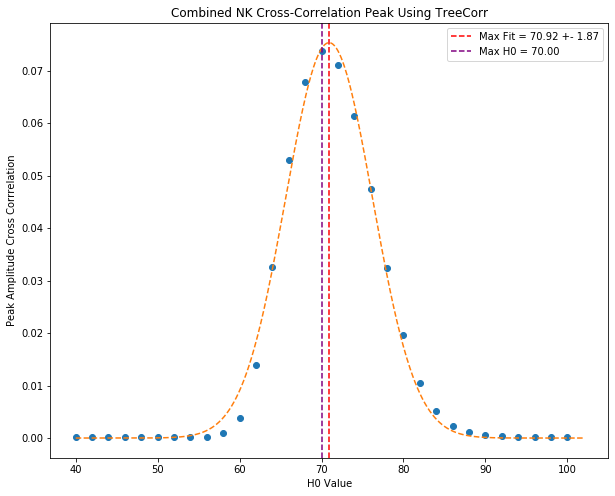

In [28]:
# 15 events
integral = integrate.simps(max_xi,h0_values)
popt, pcov = curve_fit(gaussian, h0_values,  max_xi/integral,  p0 = [1, 70, 5] )
x = numpy.arange(40,102,0.1)
y = gaussian(x,*popt)
h0_max = h0_values[numpy.argmax(max_xi)]
plt.figure(figsize=(10, 8))
plt.plot(h0_values, max_xi/integral, 'o', x, y, '--')
plt.axvline( popt[1],color = 'r', linestyle = '--', label = 'Max Fit = %.2f +- %.2f' % (popt[1], popt[2]) )
plt.axvline(h0_max ,color = 'purple', linestyle = '--', label = 'Max H0 = %.2f' % (h0_max) )
plt.title('Combined NK Cross-Correlation Peak Using TreeCorr')
plt.xlabel('H0 Value')
plt.ylabel('Peak Amplitude Cross Corrrelation')
plt.legend(loc = 'upper right')
#plt.ylim(0, numpy.max(max_xi))
plt.show()

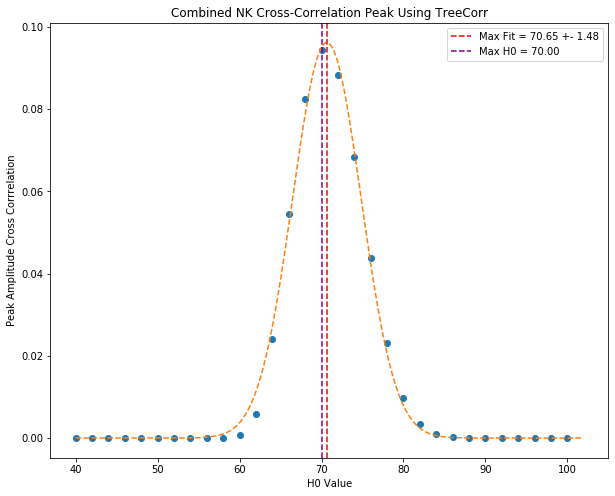

In [32]:
# 25 events
integral = integrate.simps(max_xi,h0_values)
popt, pcov = curve_fit(gaussian, h0_values,  max_xi/integral,  p0 = [1, 70, 5] )
x = numpy.arange(40,102,0.1)
y = gaussian(x,*popt)
h0_max = h0_values[numpy.argmax(max_xi)]
plt.figure(figsize=(10, 8))
plt.plot(h0_values, max_xi/integral, 'o', x, y, '--')
plt.axvline( popt[1],color = 'r', linestyle = '--', label = 'Max Fit = %.2f +- %.2f' % (popt[1], popt[2]) )
plt.axvline(h0_max ,color = 'purple', linestyle = '--', label = 'Max H0 = %.2f' % (h0_max) )
plt.title('Combined NK Cross-Correlation Peak Using TreeCorr')
plt.xlabel('H0 Value')
plt.ylabel('Peak Amplitude Cross Corrrelation')
plt.legend(loc = 'upper right')
#plt.ylim(0, numpy.max(max_xi))
plt.show()

In [8]:
outdir = 'des40a/Final_BCC_NKObjects/all_events/NKObjects'
outdir_rand = 'des40a/Final_BCC_NKObjects/all_events/NKObjects_Randoms'
h0_values =numpy.arange(40,102,2)
max_xi = plotCombineMultiply(h0_values, outdir)# outdir_rand)

In [9]:
popt, pcov = curve_fit(gaussian, h0_values,  max_xi,  p0 = [1, 70, 5] )

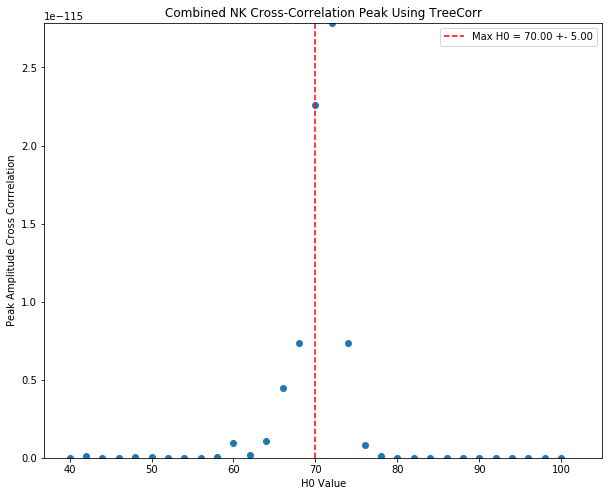

In [10]:
x = numpy.arange(40,102,0.1)
y = gaussian(x,*popt)
plt.figure(figsize=(10, 8))
plt.plot(h0_values, max_xi, 'o', x, y, '--')
plt.axvline( popt[1],color = 'r', linestyle = '--', label = 'Max H0 = %.2f +- %.2f' % (popt[1], popt[2]) )
plt.title('Combined NK Cross-Correlation Peak Using TreeCorr')
plt.xlabel('H0 Value')
plt.ylabel('Peak Amplitude Cross Corrrelation')
plt.legend(loc = 'upper right')
plt.ylim(0, numpy.max(max_xi))
plt.show()

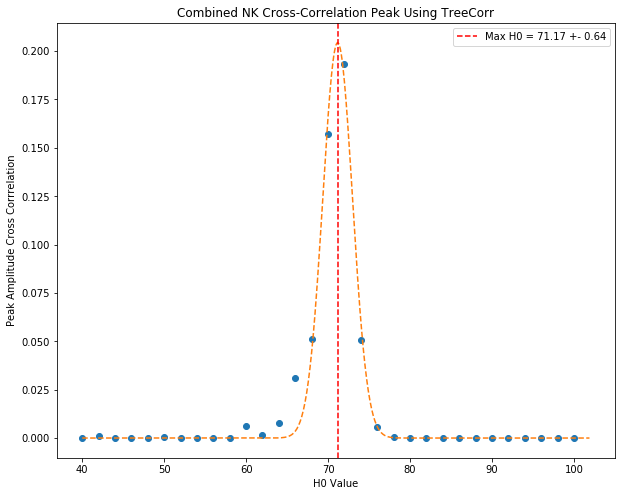

In [11]:
integral = integrate.simps(max_xi,h0_values)
popt, pcov = curve_fit(gaussian, h0_values,  max_xi/integral,  p0 = [1, 70, 5] )
x = numpy.arange(40,102,0.1)
y = gaussian(x,*popt)
plt.figure(figsize=(10, 8))
plt.plot(h0_values, max_xi/integral, 'o', x, y, '--')
plt.axvline( popt[1],color = 'r', linestyle = '--', label = 'Max H0 = %.2f +- %.2f' % (popt[1], popt[2]) )
plt.title('Combined NK Cross-Correlation Peak Using TreeCorr')
plt.xlabel('H0 Value')
plt.ylabel('Peak Amplitude Cross Corrrelation')
plt.legend(loc = 'upper right')
#plt.ylim(0, numpy.max(max_xi))
plt.show()

# BCC weights^1

In [26]:
outdir = 'des40a/Final_BCC1Weight_NKObjects/all_events/NKObjects'
outdir_rand = 'des40a/Final_BCC1Weight_NKObjects/all_events/NKObjects_Randoms'
h0_values =numpy.arange(40,102,2)
max_xi = plotCombineMultiply(h0_values, outdir)# outdir_rand)

In [27]:
popt, pcov = curve_fit(gaussian, h0_values,  max_xi,  p0 = [1, 70, 5] )

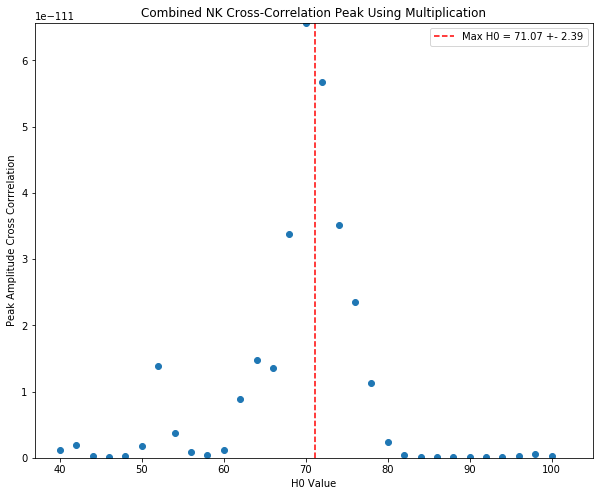

In [30]:
x = numpy.arange(40,102,0.1)
y = gaussian(x,*popt)
plt.figure(figsize=(10, 8))
plt.plot(h0_values, max_xi, 'o', x, y, '--')
plt.axvline( popt[1],color = 'r', linestyle = '--', label = 'Max H0 = %.2f +- %.2f' % (popt[1], popt[2]) )
plt.title('Combined NK Cross-Correlation Peak Using Multiplication')
plt.xlabel('H0 Value')
plt.ylabel('Peak Amplitude Cross Corrrelation')
plt.legend(loc = 'upper right')
plt.ylim(0, numpy.max(max_xi))
plt.show()

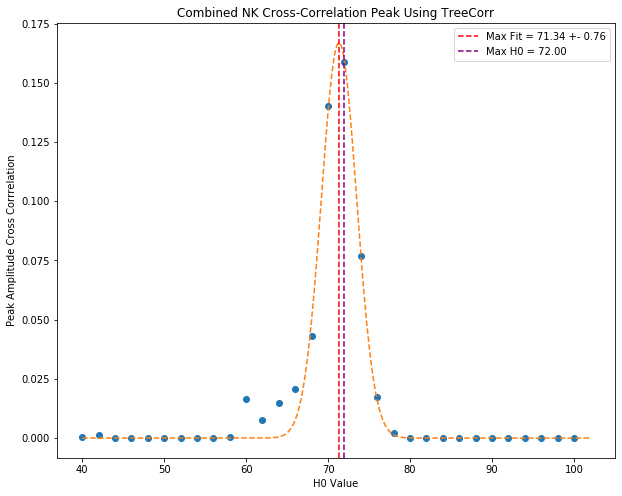

In [35]:
# 40 events
integral = integrate.simps(max_xi,h0_values)
popt, pcov = curve_fit(gaussian, h0_values,  max_xi/integral,  p0 = [1, 70, 5] )
x = numpy.arange(40,102,0.1)
y = gaussian(x,*popt)
h0_max = h0_values[numpy.argmax(max_xi)]
plt.figure(figsize=(10, 8))
plt.plot(h0_values, max_xi/integral, 'o', x, y, '--')
plt.axvline( popt[1],color = 'r', linestyle = '--', label = 'Max Fit = %.2f +- %.2f' % (popt[1], popt[2]) )
plt.axvline(h0_max ,color = 'purple', linestyle = '--', label = 'Max H0 = %.2f' % (h0_max) )
plt.title('Combined NK Cross-Correlation Peak Using TreeCorr')
plt.xlabel('H0 Value')
plt.ylabel('Peak Amplitude Cross Corrrelation')
plt.legend(loc = 'upper right')
#plt.ylim(0, numpy.max(max_xi))
plt.show()

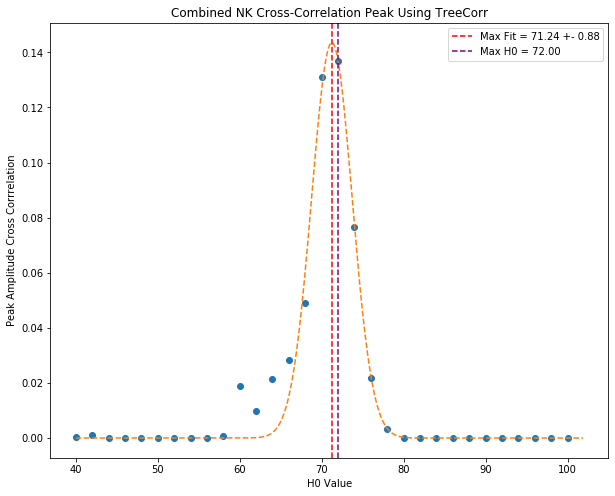

In [11]:
# 39 events without event 480
integral = integrate.simps(max_xi,h0_values)
popt, pcov = curve_fit(gaussian, h0_values,  max_xi/integral,  p0 = [1, 70, 5] )
x = numpy.arange(40,102,0.1)
y = gaussian(x,*popt)
h0_max = h0_values[numpy.argmax(max_xi)]
plt.figure(figsize=(10, 8))
plt.plot(h0_values, max_xi/integral, 'o', x, y, '--')
plt.axvline( popt[1],color = 'r', linestyle = '--', label = 'Max Fit = %.2f +- %.2f' % (popt[1], popt[2]) )
plt.axvline(h0_max ,color = 'purple', linestyle = '--', label = 'Max H0 = %.2f' % (h0_max) )
plt.title('Combined NK Cross-Correlation Peak Using TreeCorr')
plt.xlabel('H0 Value')
plt.ylabel('Peak Amplitude Cross Corrrelation')
plt.legend(loc = 'upper right')
#plt.ylim(0, numpy.max(max_xi))
plt.show()

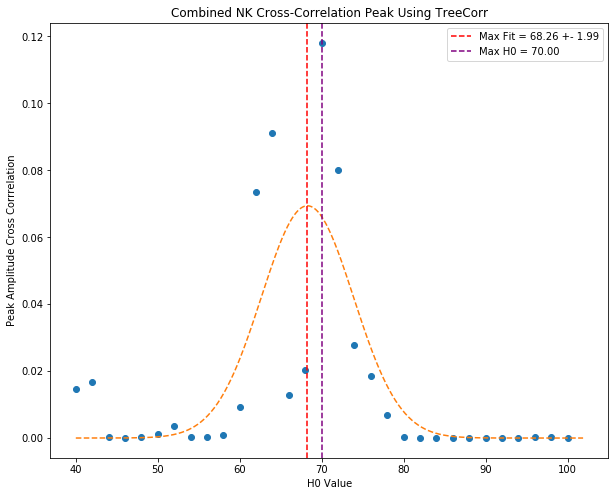

In [11]:
# 39 events without event 1987
integral = integrate.simps(max_xi,h0_values)
popt, pcov = curve_fit(gaussian, h0_values,  max_xi/integral,  p0 = [1, 70, 5] )
x = numpy.arange(40,102,0.1)
y = gaussian(x,*popt)
h0_max = h0_values[numpy.argmax(max_xi)]
plt.figure(figsize=(10, 8))
plt.plot(h0_values, max_xi/integral, 'o', x, y, '--')
plt.axvline( popt[1],color = 'r', linestyle = '--', label = 'Max Fit = %.2f +- %.2f' % (popt[1], popt[2]) )
plt.axvline(h0_max ,color = 'purple', linestyle = '--', label = 'Max H0 = %.2f' % (h0_max) )
plt.title('Combined NK Cross-Correlation Peak Using TreeCorr')
plt.xlabel('H0 Value')
plt.ylabel('Peak Amplitude Cross Corrrelation')
plt.legend(loc = 'upper right')
#plt.ylim(0, numpy.max(max_xi))
plt.show()

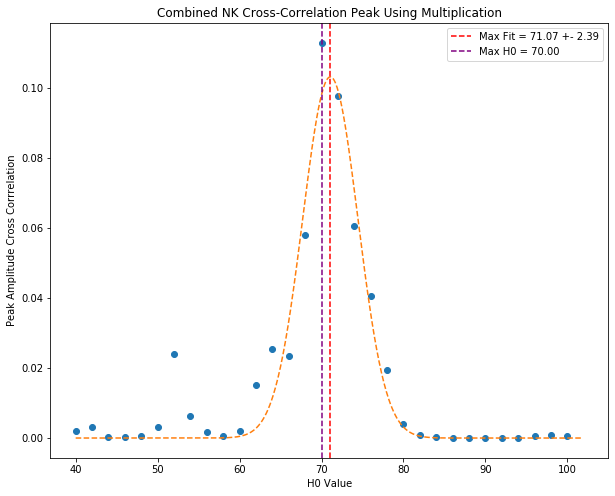

In [31]:
# 38 events without event 1987 and 36
integral = integrate.simps(max_xi,h0_values)
popt, pcov = curve_fit(gaussian, h0_values,  max_xi/integral,  p0 = [1, 70, 5] )
x = numpy.arange(40,102,0.1)
y = gaussian(x,*popt)
h0_max = h0_values[numpy.argmax(max_xi)]
plt.figure(figsize=(10, 8))
plt.plot(h0_values, max_xi/integral, 'o', x, y, '--')
plt.axvline( popt[1],color = 'r', linestyle = '--', label = 'Max Fit = %.2f +- %.2f' % (popt[1], popt[2]) )
plt.axvline(h0_max ,color = 'purple', linestyle = '--', label = 'Max H0 = %.2f' % (h0_max) )
plt.title('Combined NK Cross-Correlation Peak Using Multiplication')
plt.xlabel('H0 Value')
plt.ylabel('Peak Amplitude Cross Corrrelation')
plt.legend(loc = 'upper right')
#plt.ylim(0, numpy.max(max_xi))
plt.show()

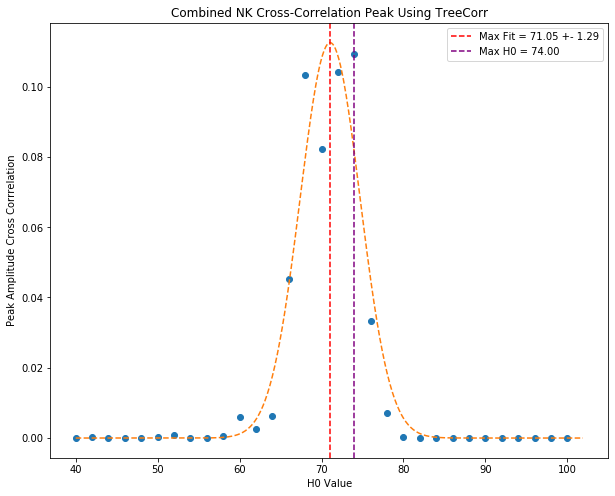

In [19]:
# 30 events
integral = integrate.simps(max_xi,h0_values)
popt, pcov = curve_fit(gaussian, h0_values,  max_xi/integral,  p0 = [1, 70, 5] )
x = numpy.arange(40,102,0.1)
y = gaussian(x,*popt)
h0_max = h0_values[numpy.argmax(max_xi)]
plt.figure(figsize=(10, 8))
plt.plot(h0_values, max_xi/integral, 'o', x, y, '--')
plt.axvline( popt[1],color = 'r', linestyle = '--', label = 'Max Fit = %.2f +- %.2f' % (popt[1], popt[2]) )
plt.axvline(h0_max ,color = 'purple', linestyle = '--', label = 'Max H0 = %.2f' % (h0_max) )
plt.title('Combined NK Cross-Correlation Peak Using TreeCorr')
plt.xlabel('H0 Value')
plt.ylabel('Peak Amplitude Cross Corrrelation')
plt.legend(loc = 'upper right')
#plt.ylim(0, numpy.max(max_xi))
plt.show()

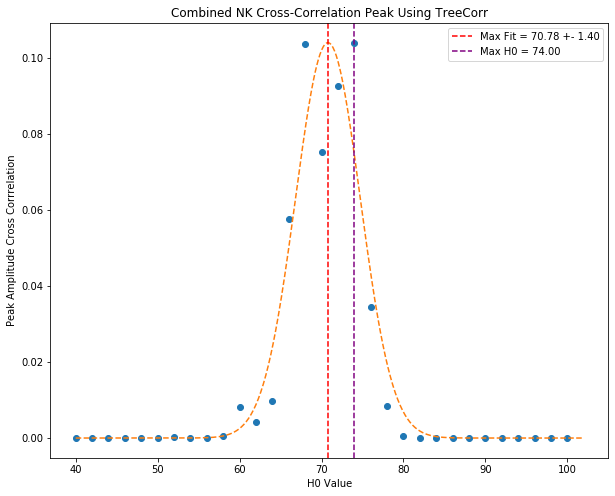

In [23]:
# 20 events
integral = integrate.simps(max_xi,h0_values)
popt, pcov = curve_fit(gaussian, h0_values,  max_xi/integral,  p0 = [1, 70, 5] )
x = numpy.arange(40,102,0.1)
y = gaussian(x,*popt)
h0_max = h0_values[numpy.argmax(max_xi)]
plt.figure(figsize=(10, 8))
plt.plot(h0_values, max_xi/integral, 'o', x, y, '--')
plt.axvline( popt[1],color = 'r', linestyle = '--', label = 'Max Fit = %.2f +- %.2f' % (popt[1], popt[2]) )
plt.axvline(h0_max ,color = 'purple', linestyle = '--', label = 'Max H0 = %.2f' % (h0_max) )
plt.title('Combined NK Cross-Correlation Peak Using TreeCorr')
plt.xlabel('H0 Value')
plt.ylabel('Peak Amplitude Cross Corrrelation')
plt.legend(loc = 'upper right')
#plt.ylim(0, numpy.max(max_xi))
plt.show()

In [8]:
def plotCombineMult(fig, h0_values, directory, rk_dir = None):
    #nk_list = [treecorr.NKCorrelation(min_sep= 10, max_sep=1000 , nbins=100) for i in range (len(h0_values))]
    nk_list = []
    for r, di, f in os.walk(directory):
        for file in f:
            if '_NKObject' in file:
                pickle_in = open(os.path.join(r, file) ,'rb')
                nk_list.append(pickle.load(pickle_in))
                #nk_combine.__iadd__(nk_corr.copy())
    if (rk_dir is not None):
        rk_list = []
        for r, di, f in os.walk(rk_dir):
            for file in f:
                if '_NKObject_Randoms' in file:
                    pickle_in = open(os.path.join(r, file) ,'rb')
                    rk_list.append(pickle.load(pickle_in))
    r_nk_tot = []
    xi_nk_tot = []
    max_r_tot = []
    #max_xi_tot = []
    # use average combination method
    for j in range(len(nk_list)):
        max_xi_tot = []
        nk_combine = treecorr.NKCorrelation(min_sep= 3, max_sep=500 , nbins=50)
        for i in range(len(h0_values)):
            rk_corr = None
            if(rk_dir is not None):
                r_nk, xi_nk, rk_corr, var_xi= NK_GW.nk_finalize(rk_list[j][i], 1)
            r_nk, xi_nk, nk_one, var_xi= NK_GW.nk_finalize(nk_list[j][i], 1, rk_corr)
            max_xi_tot.append(numpy.max(xi_nk))
        #max_r = r_nk[numpy.argmax(xi_combine)]
        #r_nk_tot.append(r_nk)
        #xi_nk_tot.append(xi_combine)
        #max_r_tot.append(max_r)
        #max_xi_tot.append(max_xi)
        # plot maximum correlation for each H_0 and fit curve
        x = h0_values
        y = max_xi_tot
        p = numpy.poly1d(numpy.polyfit(x, y, 30))
        xp = numpy.linspace(numpy.min(x), numpy.max(x), 100)
        f_max = numpy.max( p(xp))
        max_h0 = xp[numpy.argmax(p(xp))]
        axs= fig.add_subplot(2, 1, 1)
        #axs.plot(x, y, 'o', xp, p(xp), '--')
        axs.plot( xp, p(xp)/integrate.simps(max_xi_tot,h0_values), '--')
        #axs.axvline( h0_values[np.argmax(y)],color = 'r', linestyle = '--', label = 'Max H0 = %.1f' % max_h0)
        axs.set_title('Combined NK Cross-Correlation Peak Using Multiply')
        axs.set_xlabel('H0 Value')
        axs.set_ylabel('Peak Amplitude Cross Corrrelation')
        #axs.legend()
        plt.close(fig)
    return fig


In [59]:
outdir = 'des40a/Final_BCC1Weight_NKObjects/all_events/NKObjects'
outdir_rand = 'des40a/Final_BCC1Weight_NKObjects/all_events/NKObjects_Randoms'
h0_values =numpy.arange(40,102,2)
fig_combine = plt.figure(figsize=(10, 15))
fig_combine = plotCombineMult(fig_combine, h0_values, outdir)# outdir_rand)
max_xi = plotCombineMultiply(h0_values, outdir)# outdir_rand)
popt, pcov = curve_fit(gaussian, h0_values,  max_xi,  p0 = [1, 70, 5] )
integral = integrate.simps(max_xi,h0_values)
popt, pcov = curve_fit(gaussian, h0_values,  max_xi/integral,  p0 = [1, 70, 5] )
axs= fig_combine.add_subplot(2, 1, 1)
x = numpy.arange(40,102,0.1)
y = gaussian(x,*popt)
h0_max = h0_values[numpy.argmax(max_xi)]
axs.plot(h0_values, max_xi/integral, 'o', label = 'data')
axs.plot(x, y, color = 'black', label = 'fit')
axs.axvline( popt[1],color = 'r', linestyle = '--', label = 'Max Fit = %.2f +- %.2f' % (popt[1], popt[2]) )
axs.axvline(h0_max ,color = 'purple', linestyle = '--', label = 'Max H0 = %.2f' % (h0_max) )
axs.set_title('Combined NK Cross-Correlation Peak Using Multiplication')
axs.set_xlabel('H0 Value')
axs.set_ylabel('Peak Amplitude Cross Corrrelation')
axs.legend(loc = 'upper right')
#plt.ylim(0, numpy.max(max_xi))
#plt.show()

/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:5: RankWarning: Polyfit may be poorly conditioned
  """
/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:5: RankWarning: Polyfit may be poorly conditioned
  """
/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:5: RankWarning: Polyfit may be poorly conditioned
  """
/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:5: RankWarning: Polyfit may be poorly conditioned
  """

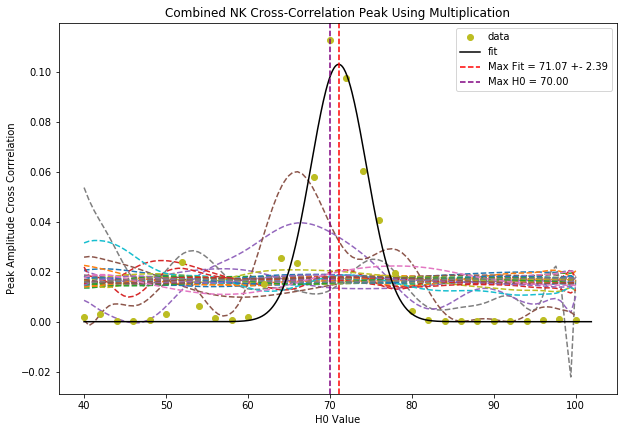

In [60]:
fig_combine

# Z_err Included

/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  
/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  
/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  
/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  
/home/s1/be

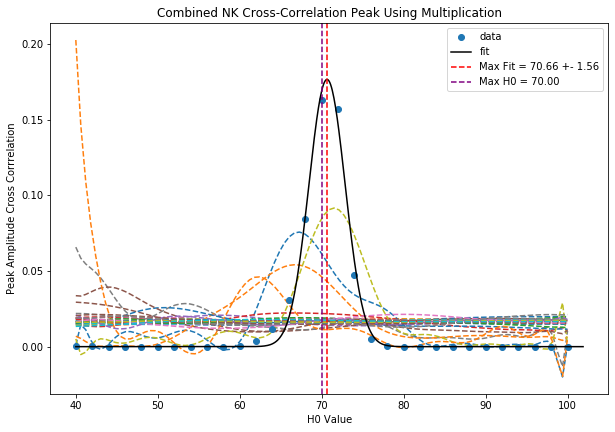

In [10]:
# 5% redshift errors
outdir = 'des40a/Final_BCC1Weight_zerr05_NKObjects/all_events/NKObjects'
#outdir_rand = 'des40a/Final_BCC1Weight_NKObjects/all_events/NKObjects_Randoms'
h0_values =numpy.arange(40,102,2)
fig_combine = plt.figure(figsize=(10, 15))
fig_combine = plotCombineMult(fig_combine, h0_values, outdir)# outdir_rand)
max_xi = plotCombineMultiply(h0_values, outdir)# outdir_rand)
popt, pcov = curve_fit(gaussian, h0_values,  max_xi,  p0 = [1, 70, 5] )
integral = integrate.simps(max_xi,h0_values)
popt, pcov = curve_fit(gaussian, h0_values,  max_xi/integral,  p0 = [1, 70, 5] )
axs= fig_combine.add_subplot(2, 1, 1)
x = numpy.arange(40,102,0.1)
y = gaussian(x,*popt)
h0_max = h0_values[numpy.argmax(max_xi)]
axs.plot(h0_values, max_xi/integral, 'o', label = 'data')
axs.plot(x, y, color = 'black', label = 'fit')
axs.axvline( popt[1],color = 'r', linestyle = '--', label = 'Max Fit = %.2f +- %.2f' % (popt[1], popt[2]) )
axs.axvline(h0_max ,color = 'purple', linestyle = '--', label = 'Max H0 = %.2f' % (h0_max) )
axs.set_title('Combined NK Cross-Correlation Peak Using Multiplication')
axs.set_xlabel('H0 Value')
axs.set_ylabel('Peak Amplitude Cross Corrrelation')
axs.legend(loc = 'upper right')
fig_combine

In [9]:
# 10% redshift errors
outdir = 'des40a/Final_BCC1Weight_zerr10_NKObjects/all_events/NKObjects'
#outdir_rand = 'des40a/Final_BCC1Weight_NKObjects/all_events/NKObjects_Randoms'
h0_values =numpy.arange(40,102,2)
fig_combine = plt.figure(figsize=(10, 15))
fig_combine = plotCombineMult(fig_combine, h0_values, outdir)# outdir_rand)
max_xi = plotCombineMultiply(h0_values, outdir)# outdir_rand)
popt, pcov = curve_fit(gaussian, h0_values,  max_xi,  p0 = [1, 70, 5] )
integral = integrate.simps(max_xi,h0_values)
popt, pcov = curve_fit(gaussian, h0_values,  max_xi/integral,  p0 = [1, 70, 5] )
axs= fig_combine.add_subplot(2, 1, 1)
x = numpy.arange(40,102,0.1)
y = gaussian(x,*popt)
h0_max = h0_values[numpy.argmax(max_xi)]
axs.plot(h0_values, max_xi/integral, 'o', label = 'data')
axs.plot(x, y, color = 'black', label = 'fit')
axs.axvline( popt[1],color = 'r', linestyle = '--', label = 'Max Fit = %.2f +- %.2f' % (popt[1], popt[2]) )
axs.axvline(h0_max ,color = 'purple', linestyle = '--', label = 'Max H0 = %.2f' % (h0_max) )
axs.set_title('Combined NK Cross-Correlation Peak Using Multiplication')
axs.set_xlabel('H0 Value')
axs.set_ylabel('Peak Amplitude Cross Corrrelation')
axs.legend(loc = 'upper right')

/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  
/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  
/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  
/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  
/home/s1/be

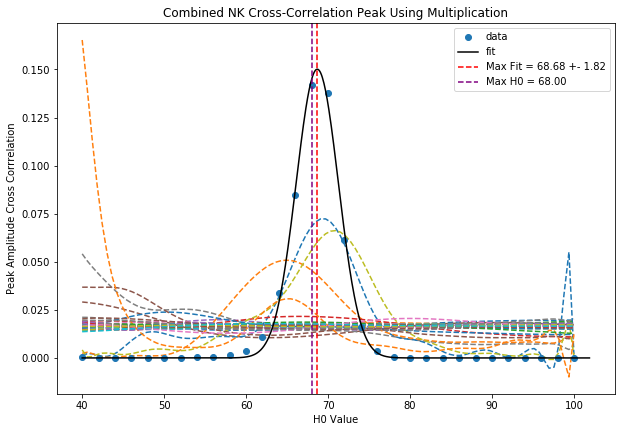

In [10]:
fig_combine

/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  
/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  
/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  
/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  
/home/s1/be

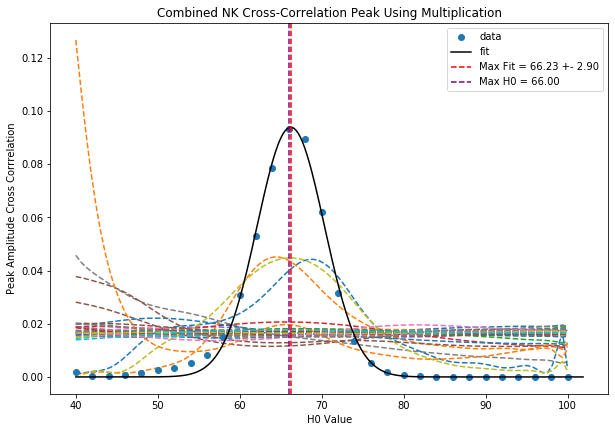

In [11]:
# 15% redshift errors
outdir = 'des40a/Final_BCC1Weight_zerr15_NKObjects/all_events/NKObjects'
#outdir_rand = 'des40a/Final_BCC1Weight_NKObjects/all_events/NKObjects_Randoms'
h0_values =numpy.arange(40,102,2)
fig_combine = plt.figure(figsize=(10, 15))
fig_combine = plotCombineMult(fig_combine, h0_values, outdir)# outdir_rand)
max_xi = plotCombineMultiply(h0_values, outdir)# outdir_rand)
popt, pcov = curve_fit(gaussian, h0_values,  max_xi,  p0 = [1, 70, 5] )
integral = integrate.simps(max_xi,h0_values)
popt, pcov = curve_fit(gaussian, h0_values,  max_xi/integral,  p0 = [1, 70, 5] )
axs= fig_combine.add_subplot(2, 1, 1)
x = numpy.arange(40,102,0.1)
y = gaussian(x,*popt)
h0_max = h0_values[numpy.argmax(max_xi)]
axs.plot(h0_values, max_xi/integral, 'o', label = 'data')
axs.plot(x, y, color = 'black', label = 'fit')
axs.axvline( popt[1],color = 'r', linestyle = '--', label = 'Max Fit = %.2f +- %.2f' % (popt[1], popt[2]) )
axs.axvline(h0_max ,color = 'purple', linestyle = '--', label = 'Max H0 = %.2f' % (h0_max) )
axs.set_title('Combined NK Cross-Correlation Peak Using Multiplication')
axs.set_xlabel('H0 Value')
axs.set_ylabel('Peak Amplitude Cross Corrrelation')
axs.legend(loc = 'upper right')
fig_combine

/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  
/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  
/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  
/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  
/home/s1/be

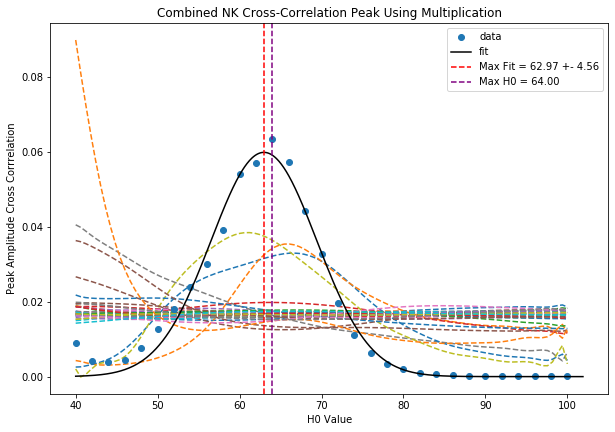

In [12]:
# 20% redshift errors
outdir = 'des40a/Final_BCC1Weight_zerr20_NKObjects/all_events/NKObjects'
#outdir_rand = 'des40a/Final_BCC1Weight_NKObjects/all_events/NKObjects_Randoms'
h0_values =numpy.arange(40,102,2)
fig_combine = plt.figure(figsize=(10, 15))
fig_combine = plotCombineMult(fig_combine, h0_values, outdir)# outdir_rand)
max_xi = plotCombineMultiply(h0_values, outdir)# outdir_rand)
popt, pcov = curve_fit(gaussian, h0_values,  max_xi,  p0 = [1, 70, 5] )
integral = integrate.simps(max_xi,h0_values)
popt, pcov = curve_fit(gaussian, h0_values,  max_xi/integral,  p0 = [1, 70, 5] )
axs= fig_combine.add_subplot(2, 1, 1)
x = numpy.arange(40,102,0.1)
y = gaussian(x,*popt)
h0_max = h0_values[numpy.argmax(max_xi)]
axs.plot(h0_values, max_xi/integral, 'o', label = 'data')
axs.plot(x, y, color = 'black', label = 'fit')
axs.axvline( popt[1],color = 'r', linestyle = '--', label = 'Max Fit = %.2f +- %.2f' % (popt[1], popt[2]) )
axs.axvline(h0_max ,color = 'purple', linestyle = '--', label = 'Max H0 = %.2f' % (h0_max) )
axs.set_title('Combined NK Cross-Correlation Peak Using Multiplication')
axs.set_xlabel('H0 Value')
axs.set_ylabel('Peak Amplitude Cross Corrrelation')
axs.legend(loc = 'upper right')
fig_combine

/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  
/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  
/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  
/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  
/home/s1/be

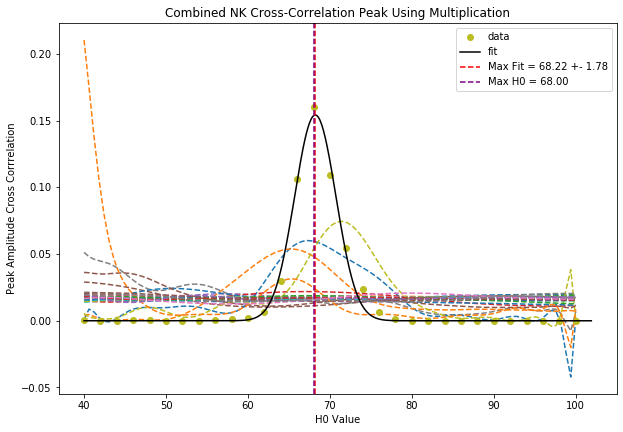

In [9]:
# 5% redshift errors with kick in z_gal
outdir = 'des40a/Final_BCC1Weight_zkick05_NKObjects/all_events/NKObjects'
#outdir_rand = 'des40a/Final_BCC1Weight_NKObjects/all_events/NKObjects_Randoms'
h0_values =numpy.arange(40,102,2)
fig_combine = plt.figure(figsize=(10, 15))
fig_combine = plotCombineMult(fig_combine, h0_values, outdir)# outdir_rand)
max_xi = plotCombineMultiply(h0_values, outdir)# outdir_rand)
popt, pcov = curve_fit(gaussian, h0_values,  max_xi,  p0 = [1, 70, 5] )
integral = integrate.simps(max_xi,h0_values)
popt, pcov = curve_fit(gaussian, h0_values,  max_xi/integral,  p0 = [1, 70, 5] )
axs= fig_combine.add_subplot(2, 1, 1)
x = numpy.arange(40,102,0.1)
y = gaussian(x,*popt)
h0_max = h0_values[numpy.argmax(max_xi)]
axs.plot(h0_values, max_xi/integral, 'o', label = 'data')
axs.plot(x, y, color = 'black', label = 'fit')
axs.axvline( popt[1],color = 'r', linestyle = '--', label = 'Max Fit = %.2f +- %.2f' % (popt[1], popt[2]) )
axs.axvline(h0_max ,color = 'purple', linestyle = '--', label = 'Max H0 = %.2f' % (h0_max) )
axs.set_title('Combined NK Cross-Correlation Peak Using Multiplication')
axs.set_xlabel('H0 Value')
axs.set_ylabel('Peak Amplitude Cross Corrrelation')
axs.legend(loc = 'upper right')
fig_combine

# TreeCorr Combine

/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  
/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  
/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  
/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  
/home/s1/be

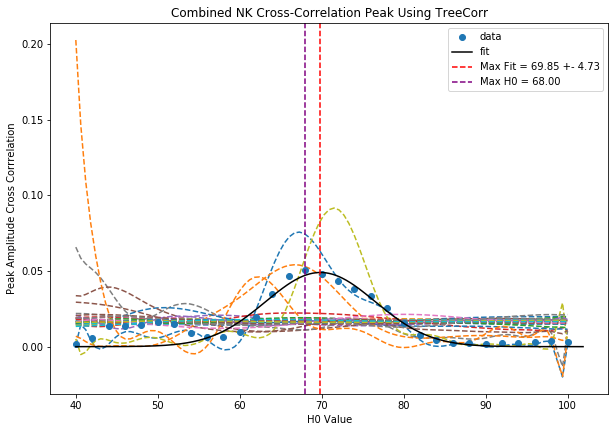

In [13]:
# 5% redshift errors
outdir = 'des40a/Final_BCC1Weight_zerr05_NKObjects/all_events/NKObjects'
#outdir_rand = 'des40a/Final_BCC1Weight_NKObjects/all_events/NKObjects_Randoms'
h0_values =numpy.arange(40,102,2)
fig_combine = plt.figure(figsize=(10, 15))
fig_combine = plotCombineMult(fig_combine, h0_values, outdir)# outdir_rand)
max_xi = plotCombineTreeCorr(h0_values, outdir)# outdir_rand)
popt, pcov = curve_fit(gaussian, h0_values,  max_xi,  p0 = [1, 70, 5] )
integral = integrate.simps(max_xi,h0_values)
popt, pcov = curve_fit(gaussian, h0_values,  max_xi/integral,  p0 = [1, 70, 5] )
axs= fig_combine.add_subplot(2, 1, 1)
x = numpy.arange(40,102,0.1)
y = gaussian(x,*popt)
h0_max = h0_values[numpy.argmax(max_xi)]
axs.plot(h0_values, max_xi/integral, 'o', label = 'data')
axs.plot(x, y, color = 'black', label = 'fit')
axs.axvline( popt[1],color = 'r', linestyle = '--', label = 'Max Fit = %.2f +- %.2f' % (popt[1], popt[2]) )
axs.axvline(h0_max ,color = 'purple', linestyle = '--', label = 'Max H0 = %.2f' % (h0_max) )
axs.set_title('Combined NK Cross-Correlation Peak Using TreeCorr')
axs.set_xlabel('H0 Value')
axs.set_ylabel('Peak Amplitude Cross Corrrelation')
axs.legend(loc = 'upper right')
fig_combine

In [12]:
# 10% redshift errors
outdir = 'des40a/Final_BCC1Weight_zerr10_NKObjects/all_events/NKObjects'
#outdir_rand = 'des40a/Final_BCC1Weight_NKObjects/all_events/NKObjects_Randoms'
h0_values =numpy.arange(40,102,2)
fig_combine = plt.figure(figsize=(10, 15))
fig_combine = plotCombineMult(fig_combine, h0_values, outdir)# outdir_rand)
max_xi = plotCombineTreeCorr(h0_values, outdir)# outdir_rand)
popt, pcov = curve_fit(gaussian, h0_values,  max_xi,  p0 = [1, 70, 5] )
integral = integrate.simps(max_xi,h0_values)
popt, pcov = curve_fit(gaussian, h0_values,  max_xi/integral,  p0 = [1, 70, 5] )
axs= fig_combine.add_subplot(2, 1, 1)
x = numpy.arange(40,102,0.1)
y = gaussian(x,*popt)
h0_max = h0_values[numpy.argmax(max_xi)]
axs.plot(h0_values, max_xi/integral, 'o', label = 'data')
axs.plot(x, y, color = 'black', label = 'fit')
axs.axvline( popt[1],color = 'r', linestyle = '--', label = 'Max Fit = %.2f +- %.2f' % (popt[1], popt[2]) )
axs.axvline(h0_max ,color = 'purple', linestyle = '--', label = 'Max H0 = %.2f' % (h0_max) )
axs.set_title('Combined NK Cross-Correlation Peak Using TreeCorr')
axs.set_xlabel('H0 Value')
axs.set_ylabel('Peak Amplitude Cross Corrrelation')
axs.legend(loc = 'upper right')

/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  
/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  
/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  
/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  
/home/s1/be

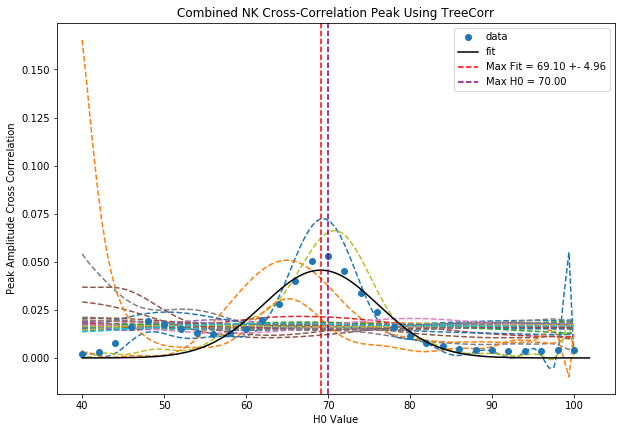

In [13]:
fig_combine

/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  
/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  
/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  
/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  
/home/s1/be

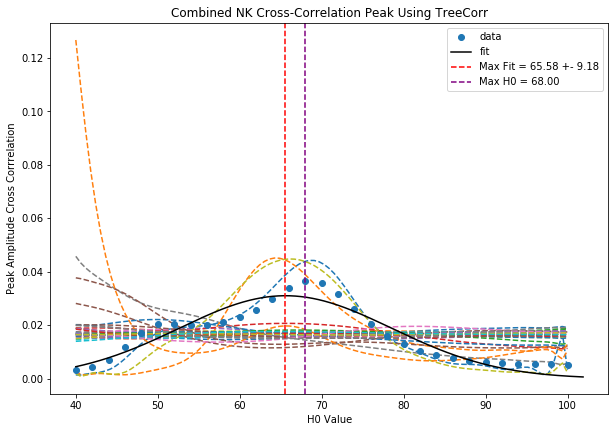

In [14]:
# 15% redshift errors
outdir = 'des40a/Final_BCC1Weight_zerr15_NKObjects/all_events/NKObjects'
#outdir_rand = 'des40a/Final_BCC1Weight_NKObjects/all_events/NKObjects_Randoms'
h0_values =numpy.arange(40,102,2)
fig_combine = plt.figure(figsize=(10, 15))
fig_combine = plotCombineMult(fig_combine, h0_values, outdir)# outdir_rand)
max_xi = plotCombineTreeCorr(h0_values, outdir)# outdir_rand)
popt, pcov = curve_fit(gaussian, h0_values,  max_xi,  p0 = [1, 70, 5] )
integral = integrate.simps(max_xi,h0_values)
popt, pcov = curve_fit(gaussian, h0_values,  max_xi/integral,  p0 = [1, 70, 5] )
axs= fig_combine.add_subplot(2, 1, 1)
x = numpy.arange(40,102,0.1)
y = gaussian(x,*popt)
h0_max = h0_values[numpy.argmax(max_xi)]
axs.plot(h0_values, max_xi/integral, 'o', label = 'data')
axs.plot(x, y, color = 'black', label = 'fit')
axs.axvline( popt[1],color = 'r', linestyle = '--', label = 'Max Fit = %.2f +- %.2f' % (popt[1], popt[2]) )
axs.axvline(h0_max ,color = 'purple', linestyle = '--', label = 'Max H0 = %.2f' % (h0_max) )
axs.set_title('Combined NK Cross-Correlation Peak Using TreeCorr')
axs.set_xlabel('H0 Value')
axs.set_ylabel('Peak Amplitude Cross Corrrelation')
axs.legend(loc = 'upper right')
fig_combine

/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  
/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  
/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  
/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  
/home/s1/be

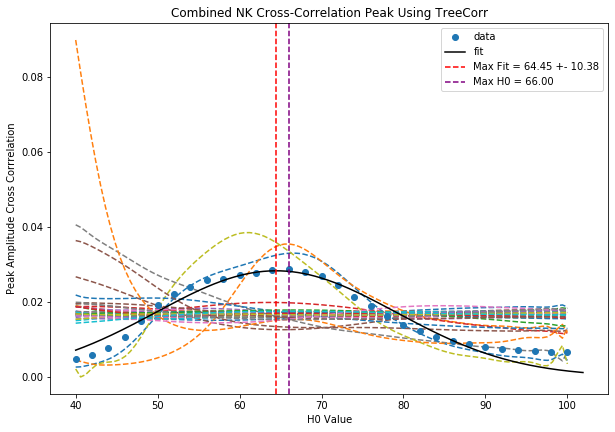

In [15]:
# 20% redshift errors
outdir = 'des40a/Final_BCC1Weight_zerr20_NKObjects/all_events/NKObjects'
#outdir_rand = 'des40a/Final_BCC1Weight_NKObjects/all_events/NKObjects_Randoms'
h0_values =numpy.arange(40,102,2)
fig_combine = plt.figure(figsize=(10, 15))
fig_combine = plotCombineMult(fig_combine, h0_values, outdir)# outdir_rand)
max_xi = plotCombineTreeCorr(h0_values, outdir)# outdir_rand)
popt, pcov = curve_fit(gaussian, h0_values,  max_xi,  p0 = [1, 70, 5] )
integral = integrate.simps(max_xi,h0_values)
popt, pcov = curve_fit(gaussian, h0_values,  max_xi/integral,  p0 = [1, 70, 5] )
axs= fig_combine.add_subplot(2, 1, 1)
x = numpy.arange(40,102,0.1)
y = gaussian(x,*popt)
h0_max = h0_values[numpy.argmax(max_xi)]
axs.plot(h0_values, max_xi/integral, 'o', label = 'data')
axs.plot(x, y, color = 'black', label = 'fit')
axs.axvline( popt[1],color = 'r', linestyle = '--', label = 'Max Fit = %.2f +- %.2f' % (popt[1], popt[2]) )
axs.axvline(h0_max ,color = 'purple', linestyle = '--', label = 'Max H0 = %.2f' % (h0_max) )
axs.set_title('Combined NK Cross-Correlation Peak Using TreeCorr')
axs.set_xlabel('H0 Value')
axs.set_ylabel('Peak Amplitude Cross Corrrelation')
axs.legend(loc = 'upper right')
fig_combine

/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  
/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  
/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  
/home/s1/berlfein/.conda/envs/federico/lib/python3.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  
/home/s1/be

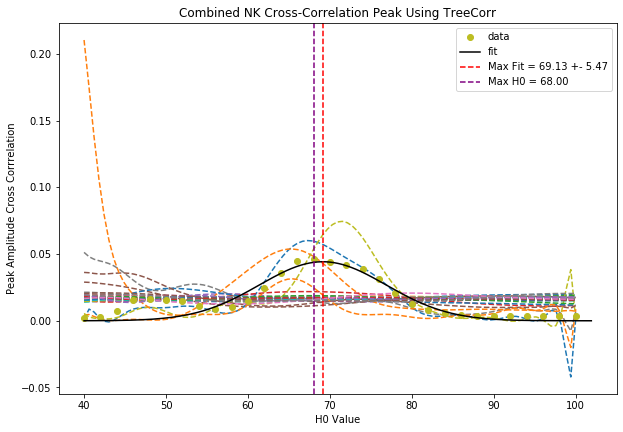

In [10]:
# 20% redshift errors
outdir = 'des40a/Final_BCC1Weight_zkick05_NKObjects/all_events/NKObjects'
#outdir_rand = 'des40a/Final_BCC1Weight_NKObjects/all_events/NKObjects_Randoms'
h0_values =numpy.arange(40,102,2)
fig_combine = plt.figure(figsize=(10, 15))
fig_combine = plotCombineMult(fig_combine, h0_values, outdir)# outdir_rand)
max_xi = plotCombineTreeCorr(h0_values, outdir)# outdir_rand)
popt, pcov = curve_fit(gaussian, h0_values,  max_xi,  p0 = [1, 70, 5] )
integral = integrate.simps(max_xi,h0_values)
popt, pcov = curve_fit(gaussian, h0_values,  max_xi/integral,  p0 = [1, 70, 5] )
axs= fig_combine.add_subplot(2, 1, 1)
x = numpy.arange(40,102,0.1)
y = gaussian(x,*popt)
h0_max = h0_values[numpy.argmax(max_xi)]
axs.plot(h0_values, max_xi/integral, 'o', label = 'data')
axs.plot(x, y, color = 'black', label = 'fit')
axs.axvline( popt[1],color = 'r', linestyle = '--', label = 'Max Fit = %.2f +- %.2f' % (popt[1], popt[2]) )
axs.axvline(h0_max ,color = 'purple', linestyle = '--', label = 'Max H0 = %.2f' % (h0_max) )
axs.set_title('Combined NK Cross-Correlation Peak Using TreeCorr')
axs.set_xlabel('H0 Value')
axs.set_ylabel('Peak Amplitude Cross Corrrelation')
axs.legend(loc = 'upper right')
fig_combine